In [11]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import string
from nltk.stem import WordNetLemmatizer
#import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from joblib import Parallel, delayed

from wordcloud import WordCloud
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

Remove:
* Empty Bodies
* Empty Punchlines
* Empty Jokes remove
* Check if punchline in body; yes —> then remove from joke column (otherwise double counted/included) or better: then take body instead of joke
* 0.0-Score Jokes!? Undersampling or delete entirely?
* Preprocessing all, inlcuding removing inappropriate jokes
* selective stopword removal
* word embedding

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# load initial data
df = pd.read_csv('../data/external/data_from_source.csv')

# Remove jokes

*   dublicates
*   empty (body, joke, punchline, score)
*   inappropriate
*   non-sense jokes



In [3]:
# Total number of jokes
len(df)

573408

## Duplicates

In [4]:
# remove dublicates
df = df[~df.duplicated()]

print(len(df))

573397


## Missing Jokes

In [5]:
df.isna().sum()

joke            6
body         5763
punchline      69
score          69
date          108
dtype: int64

In [6]:
# remove empty rows --> date does not need to be removed

df = df[(~df.body.isnull()) & (~df.joke.isnull()) & (~df.punchline.isnull())]

print(len(df))

567591


In [7]:
df.isna().sum()

joke          0
body          0
punchline     0
score         0
date         33
dtype: int64

## Inappropriate Jokes

In [8]:
# there are some inappropriate jokes, e.g sexual orientation, racsim etc
df.loc[~df.body.isnull()].iloc[3]

joke         Two Gay guys are lying on their bed... Two gay guys are lying on their bed.  The first guy asks the second:  "Do you hate me?"  Second Guy replies , "No..."  "Do you find me annoying?" - "No"  "Do you think I'm ugly?" - "No"  "Is there some one else?" - "No"  "Do you want me to leave? "   "Don't you want to have sex with me?" Second guy says "I do! But why are you asking me these stupid questions?"  First Guy: "Then why are you facing towards me!?" 
body                              Two gay guys are lying on their bed.  The first guy asks the second:\n\n"Do you hate me?"\n\nSecond Guy replies , "No..."\n\n"Do you find me annoying?" - "No"\n\n"Do you think I'm ugly?" - "No"\n\n"Is there some one else?" - "No"\n\n"Do you want me to leave? " \n\n"Don't you want to have sex with me?"\nSecond guy says "I do! But why are you asking me these stupid questions?"\n\nFirst Guy: "Then why are you facing towards me!?"\n
punchline                                                         

In [9]:
# word list which needed to be filtered out

offensive_words = [
    "nigger", "kike", "faggot", "retard", "sperg",
    "tranny", "trannie", "shemale", "shim", "sodomite",
    "cunt", "whore", "dyke",
    "spic", "chink", "gook", "wetback", "beaner",
    "coon", "jigaboo", "porch monkey", "tar baby",
    "raghead", "towelhead",
    "fag", "homo", "queer", "lesbo", "pansy",
     "cripple", "mongoloid",
    "rape", "molest", "pedophile", "child molester",
    "jihadi", "lardass", "anorexic", "bulimic",
    "slave", "plantation", "massa", "lynch",
    "gas chamber", "holocaust", "nazi", "hitler",
    "kkk", "klan", "white supremacist",
    "suicide", "kill yourself", "self-harm", "cutting",
    "pro-anorexia", "pro-bulimia", "thinspo", "bonespo",
    "schizo", "gimp", "invalid", "gay"
]



def preprocess_jokes(df, offensive_list,joke_column='joke'):
    """
    Preprocess the jokes in a DataFrame for simple machine learning models.

    Args:
        df (pd.DataFrame): DataFrame containing the jokes.
        joke_column (str): The column name containing the jokes.

    Returns:
        pd.DataFrame: DataFrame with an additional 'cleaned_joke' column.
        int: Count of offensive jokes removed.
        int: Count of jokes removed due to insufficient length.
    """

    def clean_joke(joke):
        """
        Clean an individual joke.

        Args:
            joke (str): The joke to clean.

        Returns:
            str: Cleaned joke.
        """
        # Lowercase the joke
        joke = joke.lower()

        # Remove URLs and non-joke content
        joke = re.sub(r'http\S+', '', joke)  # Remove URLs
        joke = re.sub(r'\s+', ' ', joke).strip()  # Remove excessive whitespace and trim

        # Remove special characters and digits
        joke = joke.translate(str.maketrans('', '', string.punctuation + string.digits))

        return joke

    def is_offensive(joke):
            """
            Check if the joke contains any offensive words.

            Args:
                joke (str): The joke to check.

            Returns:
                bool: True if the joke contains offensive words, False otherwise.
            """
            return any(word in joke for word in offensive_list)

    offensive_count = 0
    length_count = 0
    longer_count = 0

    def process_row(joke):
        nonlocal offensive_count, length_count, longer_count

        if not isinstance(joke, str):
            return None

        cleaned = clean_joke(joke)

        # filter out jokes which are offensive
        if is_offensive(cleaned):
            offensive_count += 1
            return None
        # filter out jokes whcih are under 10 characters of length
        if len(cleaned) <= 10:
            length_count += 1
            return None

        # filter out jokes whcih are over 200 characters of length
        if len(cleaned) > 200:
            longer_count += 1
            return None

        return cleaned

    df['cleaned_joke'] = Parallel(n_jobs=-1)(delayed(process_row)(row) for row in df[joke_column])

    # Drop rows with None in 'cleaned_joke' column
    df = df.dropna(subset=['cleaned_joke'])

    return df, offensive_count, length_count, longer_count

In [20]:
clean_df, offensive_count, length_count, longer_count = preprocess_jokes(df,  offensive_words)

print(f"Cleaned Jokes: {len(clean_df)}")
print(f"Offensive Jokes Removed: {offensive_count}")
print(f"Jokes Removed Due to Length: {length_count+longer_count}")

Cleaned Jokes: 425576
Offensive Jokes Removed: 25765
Jokes Removed Due to Length: 116250


## Exclude Year 2016

In [22]:
# transform date to float
clean_df['date'] = clean_df['date'].astype(np.float64)


# filter out all dates prior year 2016 (1451602800) based on Unix time
clean_df = clean_df[clean_df['date'] > 1451602800.0]


/tmp/ipykernel_17451/178479642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['date'] = clean_df['date'].astype(np.float64)


In [23]:
print(len(clean_df))

332675


## Alltering jokes where puchline is also in body

In [24]:
# take body if punchline is in body else take both

clean_df['joke_new'] = clean_df.apply(
    lambda row: row['body'] if row['punchline'].rstrip('.').strip() in row['body'] or len(row['punchline'].split()) < 3 else row['punchline'] + " " + row['body'],
    axis=1
)

## Transform Score column and Create class column

In [25]:
import numpy as np

def preprocess_and_categorize(df, joke_column='joke_new',  num_classes=6):

    df['log_score'] = np.log1p(df['score'])
    # Cut off at the 95th quantile
    quantile_95 = df['log_score'].quantile(0.95)
    df = df[df['log_score'] <= quantile_95]


    quintiles = pd.qcut(df['log_score'], q=num_classes, labels=False, duplicates='drop') + 1
    df['score_class'] = quintiles

    return df


df_copy = preprocess_and_categorize(clean_df)

/tmp/ipykernel_17451/3569998123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_class'] = quintiles


In [26]:
df_copy['score_class'].value_counts()

score_class
1    120299
5     52372
3     51838
4     49984
2     41555
Name: count, dtype: int64

## Undersampling

In [27]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiating RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Undersampling
X_resampled, y_resampled = rus.fit_resample(df_copy.drop(columns=['score_class']), df_copy['score_class'])

# Creating a DataFrame from the undersampled data
df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=df_copy.drop(columns=['score_class']).columns),
                         pd.DataFrame(y_resampled, columns=['score_class'])], axis=1)


In [28]:
df_balanced.score_class.value_counts()

score_class
1    41555
2    41555
3    41555
4    41555
5    41555
Name: count, dtype: int64

In [29]:
print(len(df_balanced))

207775


In [ ]:
# Svaing the preprocessed data
df_balanced.to_csv('../data/interim/ready_for_model.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


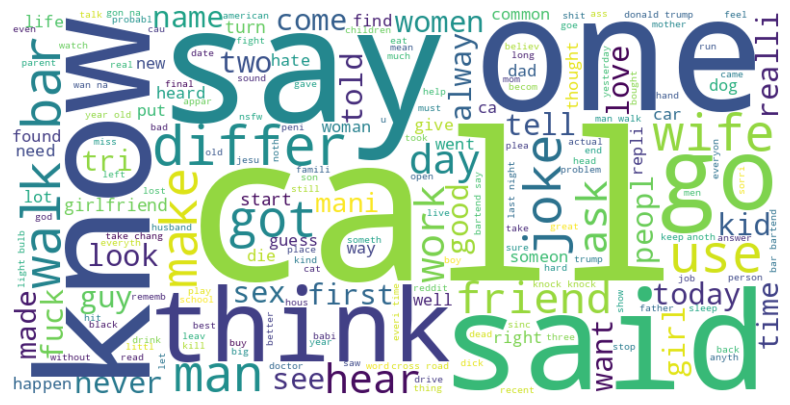

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

# Pre-compute stop words and initialize stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Tokenize, filter non-alphanumeric tokens, remove stopwords, and apply stemming in one pass
    return ' '.join(stemmer.stem(word) for word in word_tokenize(text) if word.isalnum() and word.lower() not in stop_words)

def create_word_cloud(text_column):
    # Preprocess and combine text in one step
    combined_text = ' '.join(text_column.apply(preprocess_text))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()



# all jokes
create_word_cloud(df_balanced["joke"])